In [1]:
!pip install python-louvain
!pip install cdlib
import pandas as pd                # manipulación de datos
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from itertools import cycle
import community
import cdlib
from cdlib import algorithms


Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'bayanpy', 'infomap', 'wurlitzer', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


In [2]:
# Definir las rutas de los archivos CSV
path1 = "srep00196-s2.csv"
path2 = "srep00196-s3.csv"

In [3]:
# Leer el primer archivo CSV
df1 = pd.read_csv(path1, comment='#', header=None, names=["Ingredient 1", "Ingredient 2", "frecuencia"])
df2 = pd.read_csv(path2, comment='#', header=None, delimiter=' ')
#Creación de columnas
nuevas_columnas = df2[0].str.split(',', expand=True)
#Asignación de nombre de las columnas
nuevas_columnas.columns = ['Type of cuisine'] + ['Ingredient_' + str(i) for i in range(1, len(nuevas_columnas.columns))]
# Reemplazar los valores nulos por una cadena vacía
nuevas_columnas.fillna('', inplace=True)
df2= nuevas_columnas

In [4]:
print(df1.info())
print(df1.head(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221777 entries, 0 to 221776
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Ingredient 1  221777 non-null  object
 1   Ingredient 2  221777 non-null  object
 2   frecuencia    221777 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.1+ MB
None
        Ingredient 1   Ingredient 2  frecuencia
0  black_sesame_seed      rose_wine           3
1             fennel     wild_berry           5
2       comte_cheese          grape          57
3               nira       raw_beef           1
4      corn_mint_oil  parsnip_fruit           2
5            soybean  vegetable_oil           1
6        bell_pepper     naranjilla           5
7            chervil       crayfish           1


In [5]:
print(df1.isnull().sum())

Ingredient 1    0
Ingredient 2    0
frecuencia      0
dtype: int64


In [6]:
# Obtener estadísticas descriptivas de las columnas numéricas
print(df1.describe())

          frecuencia
count  221777.000000
mean        9.077163
std        15.570641
min         1.000000
25%         1.000000
50%         2.000000
75%         9.000000
max       227.000000


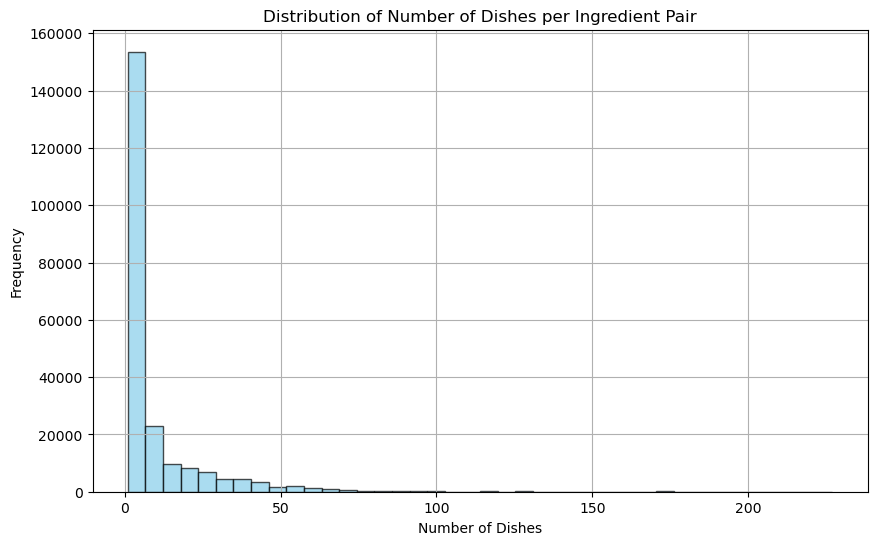

In [7]:
# Histogram for the number of dishes in which ingredient pairs are present
plt.figure(figsize=(10, 6))
plt.hist(df1.iloc[:, 2], bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Dishes per Ingredient Pair")
plt.xlabel("Number of Dishes")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

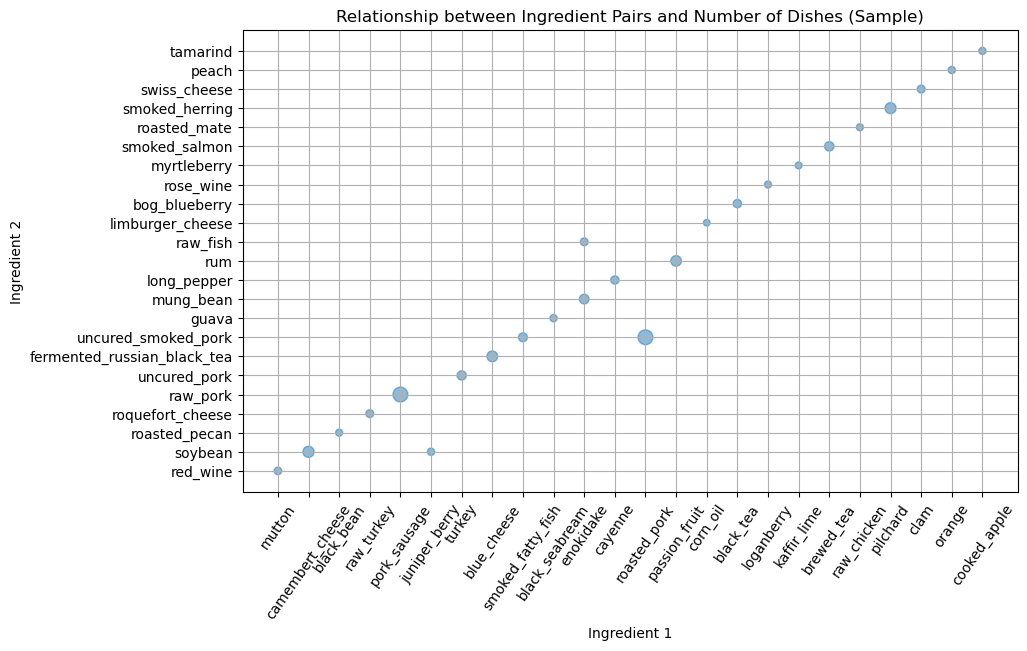

In [8]:
# Filtrar filas con un número de platos mayor a 10
df1_filtrado = df1[df1.iloc[:, 2] > 20]

# Seleccionar una muestra aleatoria de 25 filas del DataFrame filtrado
df1_sample = df1_filtrado.sample(n=25, random_state=42)

# Scatter plot con la muestra aleatoria
plt.figure(figsize=(10, 6))
plt.scatter(df1_sample['Ingredient 1'], df1_sample['Ingredient 2'], s=df1_sample.iloc[:, 2], alpha=0.5)
plt.title("Relationship between Ingredient Pairs and Number of Dishes (Sample)")
plt.xlabel("Ingredient 1")
plt.ylabel("Ingredient 2")
plt.xticks(rotation=55)  # Rotar los nombres en el eje x
plt.grid(True)
plt.show()


In [9]:
print(df2.info())
print(df2.head(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56498 entries, 0 to 56497
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Type of cuisine  56498 non-null  object
 1   Ingredient_1     56498 non-null  object
 2   Ingredient_2     56498 non-null  object
 3   Ingredient_3     56498 non-null  object
 4   Ingredient_4     56498 non-null  object
 5   Ingredient_5     56498 non-null  object
 6   Ingredient_6     56498 non-null  object
 7   Ingredient_7     56498 non-null  object
 8   Ingredient_8     56498 non-null  object
 9   Ingredient_9     56498 non-null  object
 10  Ingredient_10    56498 non-null  object
 11  Ingredient_11    56498 non-null  object
 12  Ingredient_12    56498 non-null  object
 13  Ingredient_13    56498 non-null  object
 14  Ingredient_14    56498 non-null  object
 15  Ingredient_15    56498 non-null  object
 16  Ingredient_16    56498 non-null  object
 17  Ingredient_17    56498 non-null

In [10]:
df2.head(10)

Type of cuisine   Ingredient_1 Ingredient_2 Ingredient_3  Ingredient_4  \
0         African        chicken     cinnamon    soy_sauce         onion   
1         African  cane_molasses       ginger        cumin        garlic   
2         African         butter       pepper        onion      cardamom   
3         African      olive_oil       pepper        wheat          beef   
4         African          honey        wheat        yeast                 
5         African         tomato     cilantro  lemon_juice         onion   
6         African          wheat      cassava                              
7         African      olive_oil        onion       potato  black_pepper   
8         African         tomato    fenugreek       pepper         onion   
9         African         banana                                           

  Ingredient_5  Ingredient_6    Ingredient_7 Ingredient_8 Ingredient_9  ...  \
0       ginger                                                          ...   
1     tamarind         bread       coriander      vinegar        onion  ...   
2      cayenne        ginger  cottage_cheese       garlic     brassica  ...   
3        onion      cardamom           cumin       garlic         rice  ...   
4                                                                       ...   
5      cayenne      scallion                                            ...   
6                                                                       ...   
7        cumin        carrot         cabbage     turmeric               ...   
8       potato  black_pepper          ginger       carrot       garlic  ...   
9                                                                       ...   

  Ingredient_23 Ingredient_24 Ingredient_25 Ingredient_26 Ingredient_27  \
0                                                                         
1                                                                         
2                                                                         
3                                                                         
4                                                                         
5                                                                         
6                                                                         
7                                                                         
8                                                                         
9                                                                         

  Ingredient_28 Ingredient_29 Ingredient_30 Ingredient_31 Ingredient_32  
0                                                                        
1                                                                        
2                                                                        
3                                                                        
4                                                                        
5                                                                        
6                                                                        
7                                                                        
8                                                                        
9                                                                        

[10 rows x 33 columns]

In [11]:
# Count the number of recipes per type of cuisine
num_recipes_per_cuisine = df2['Type of cuisine'].value_counts()

# Count the number of ingredients per type of cuisine
num_ingredients_per_cuisine = df2.drop(columns=['Type of cuisine']).apply(lambda x: x.notnull().sum(), axis=1)

# Print the statistical summary
print("Number of Recipes per Type of Cuisine:\n", num_recipes_per_cuisine)


Number of Recipes per Type of Cuisine:
 NorthAmerican       41524
SouthernEuropean     4180
LatinAmerican        2917
WesternEuropean      2659
EastAsian            2512
MiddleEastern         645
SouthAsian            621
SoutheastAsian        457
EasternEuropean       381
African               352
NorthernEuropean      250
Name: Type of cuisine, dtype: int64


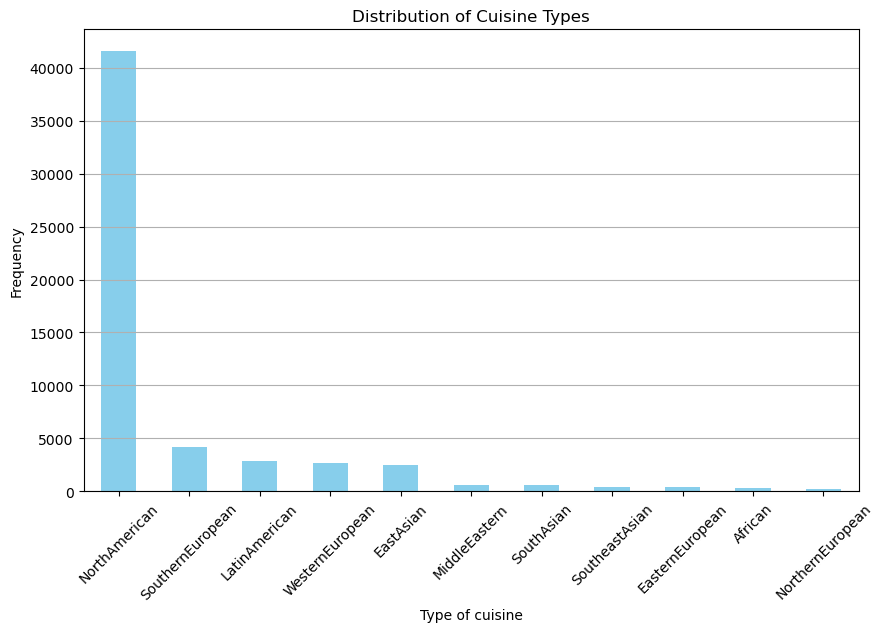

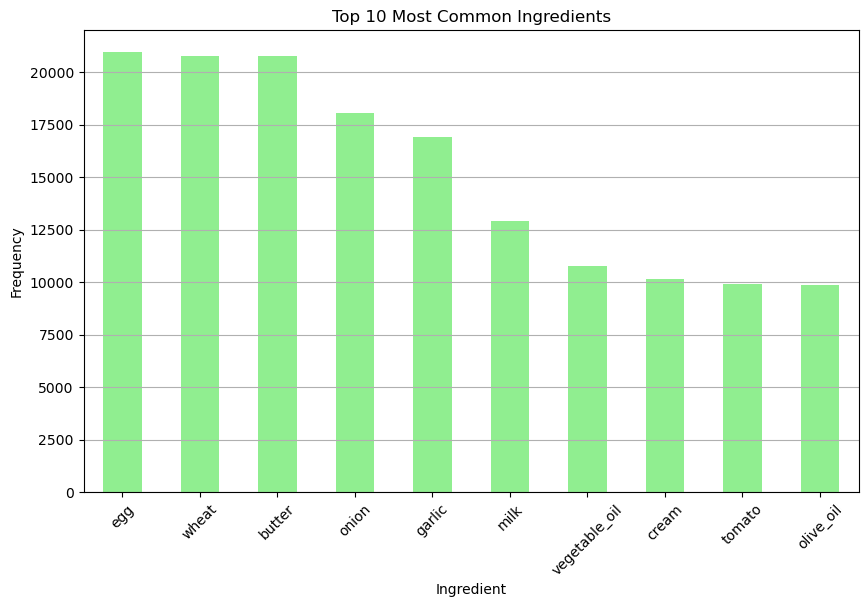

In [12]:
# Histograma para mostrar la distribución de tipos de cocina
plt.figure(figsize=(10, 6))
df2['Type of cuisine'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Cuisine Types")
plt.xlabel("Type of cuisine")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# Eliminar el valor vacío ('') antes de contar los ingredientes más comunes
df2_stacked = df2.drop(columns=['Type of cuisine']).stack()
df2_stacked = df2_stacked[df2_stacked != '']

# Gráfico de barras para mostrar los ingredientes más comunes
plt.figure(figsize=(10, 6))
df2_stacked.value_counts().head(10).plot(kind='bar', color='lightgreen')
plt.title("Top 10 Most Common Ingredients")
plt.xlabel("Ingredient")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



In [13]:
# Crear un grafo no dirigido
G1 = nx.Graph()

# Agregar nodos y aristas al grafo solo para pares de comidas con más de 10 de frecuencia
for _, row in df1.iterrows():
    ingrediente1 = row["Ingredient 1"]
    ingrediente2 = row["Ingredient 2"]
    frecuencia = row["frecuencia"]
    if frecuencia > 40:
        G1.add_edge(ingrediente1, ingrediente2, weight=frecuencia)



In [14]:
# Visualizar información básica de la red
print("Número de nodos:", nx.number_of_nodes(G1))
print("Número de bordes:", nx.number_of_edges(G1))

Número de nodos: 286
Número de bordes: 11810


In [15]:
# Central measures
print("Central Measures:")
print("Average Clustering Coefficient:", nx.average_clustering(G1))
print("Average Degree:", np.mean([degree for node, degree in G1.degree()]))
print("Average Closeness Centrality:", np.mean(list(nx.closeness_centrality(G1).values())))
print("Average Betweenness Centrality:", np.mean(list(nx.betweenness_centrality(G1).values())))

# Global measures
print("\nGlobal Measures:")
print("Number of Nodes:", G1.number_of_nodes())
print("Number of Edges:", G1.number_of_edges())
print("Density:", nx.density(G1))
#print("Diameter:", nx.diameter(G1))


Central Measures:
Average Clustering Coefficient: 0.8161067063743391
Average Degree: 82.58741258741259
Average Closeness Centrality: 0.509842744418074
Average Betweenness Centrality: 0.0025607330648101593

Global Measures:
Number of Nodes: 286
Number of Edges: 11810
Density: 0.28978039504355296


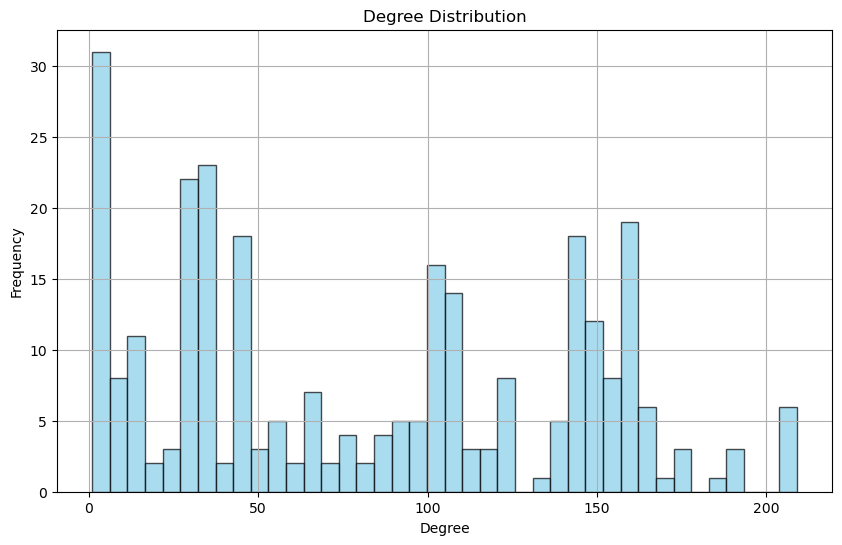

In [16]:
# Graficar el histograma de la distribución de grado
grados = [grado for nodo, grado in G1.degree()]
plt.figure(figsize=(10, 6))
plt.hist(grados, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Degree Distribution")

plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

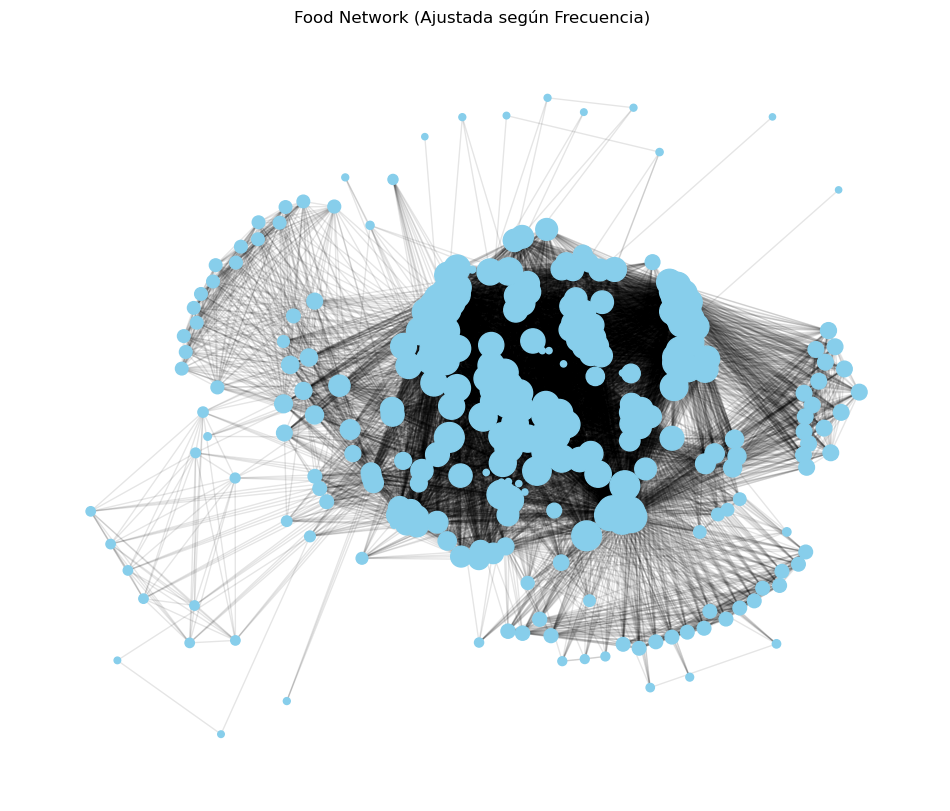

In [17]:
# Ejemplo de ajuste de la visualización de la red
plt.figure(figsize=(12, 10))

min_size = 20  # Tamaño mínimo del nodo
max_size = 500  # Tamaño máximo del nodo

# Obtener los grados de los nodos en el grafo G1
grados1 = dict(G1.degree())

# Crear un diccionario de tamaños de nodos basados en los grados
node_sizes1 = {n: min_size + (max_size - min_size) * (grados1[n] - min(grados1.values())) / (max(grados1.values()) - min(grados1.values())) for n in G1.nodes()}

# Posiciones de los nodos usando un algoritmo de posicionamiento personalizado (por ejemplo, Kamada-Kawai)
pos1 = nx.kamada_kawai_layout(G1)

# Dibujar los nodos
nx.draw_networkx_nodes(G1, pos1, node_size=[node_sizes1[n] for n in G1.nodes()], node_color='skyblue')

# Dibujar las aristas
nx.draw_networkx_edges(G1, pos1, alpha=0.1)


# Añadir etiquetas de nodos
#nx.draw_networkx_labels(G1, pos1, font_size=5, font_color='black')


# Título del gráfico
plt.title("Food Network (Ajustada según Frecuencia) ")

# Mostrar el gráfico
plt.axis('off')  # Desactivar ejes
plt.show()



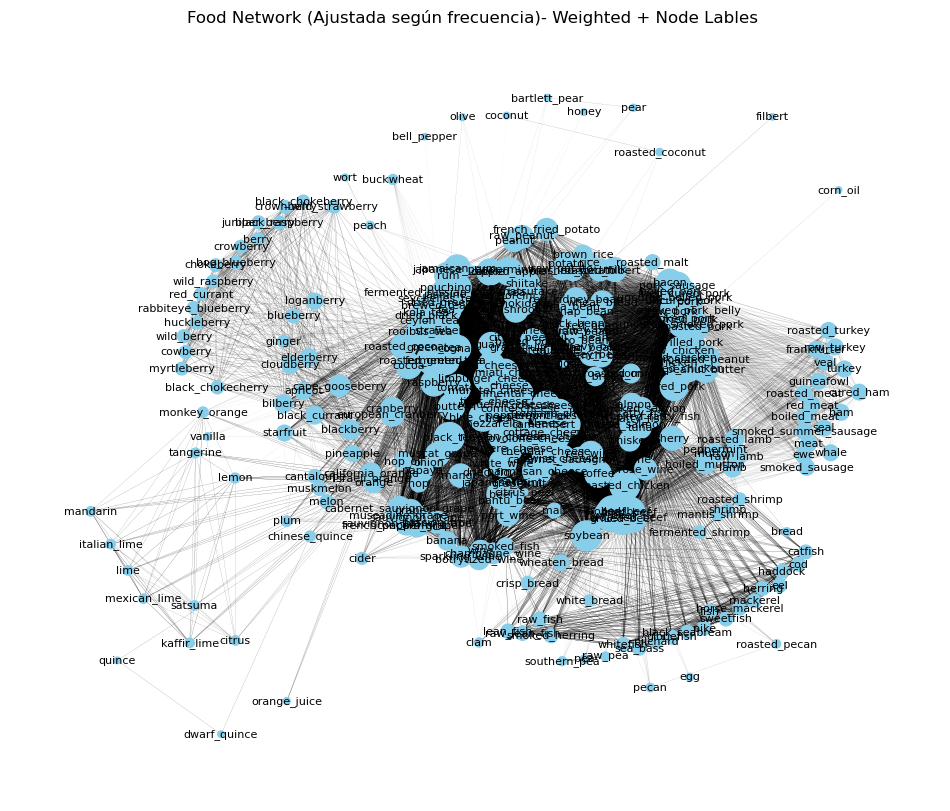

In [18]:
# Ejemplo de ajuste de la visualización de la red
plt.figure(figsize=(12, 10))

min_size = 20  # Tamaño mínimo del nodo
max_size = 500  # Tamaño máximo del nodo

# Obtener los grados de los nodos en el grafo G1
grados1 = dict(G1.degree())

# Crear un diccionario de tamaños de nodos basados en los grados
node_sizes1 = {n: min_size + (max_size - min_size) * (grados1[n] - min(grados1.values())) / (max(grados1.values()) - min(grados1.values())) for n in G1.nodes()}

# Obtener los pesos de las aristas
pesos = nx.get_edge_attributes(G1, 'weight')

# Normalizar los pesos al rango [0.01, 1]
max_peso = max(pesos.values())
min_peso = min(pesos.values())
pesos_normalizados = {e: 0.01 + (1 - 0.01) * ((pesos[e] - min_peso) / (max_peso - min_peso)) for e in pesos}

# Posiciones de los nodos usando un algoritmo de posicionamiento personalizado (por ejemplo, Kamada-Kawai)
pos1 = nx.kamada_kawai_layout(G1)

# Dibujar los nodos
nx.draw_networkx_nodes(G1, pos1, node_size=[node_sizes1[n] for n in G1.nodes()], node_color='skyblue')

# Dibujar las aristas con ancho proporcional al peso
nx.draw_networkx_edges(G1, pos1, width=[pesos_normalizados[e] for e in G1.edges()])

# Añadir etiquetas de nodos
nx.draw_networkx_labels(G1, pos1, font_size=8, font_color='black')


# Título del gráfico
plt.title("Food Network (Ajustada según frecuencia)- Weighted + Node Lables ")

# Mostrar el gráfico
plt.axis('off')  # Desactivar ejes
plt.show()


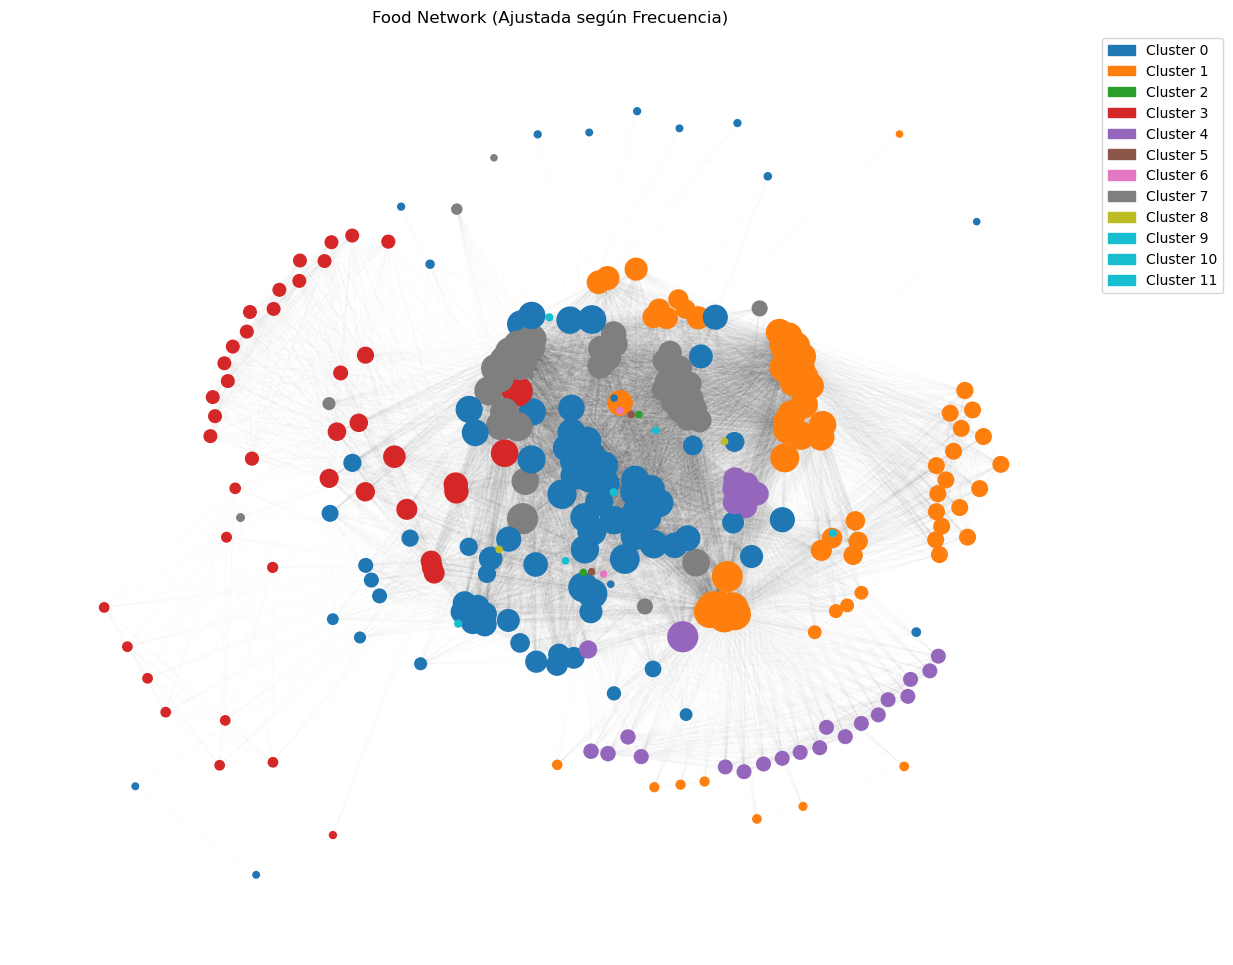

In [19]:
# Colorear los nodos según los clusters


# Detectar comunidades utilizando el algoritmo de Louvain
partition = community.best_partition(G1)



# Colorear los nodos según los clústeres
node_colors = [partition[node] for node in G1.nodes()]


# Ejemplo de ajuste de la visualización de la red
plt.figure(figsize=(14, 12))

min_size = 20  # Tamaño mínimo del nodo
max_size = 500  # Tamaño máximo del nodo

# Obtener los grados de los nodos en el grafo G1
grados1 = dict(G1.degree())

# Crear un diccionario de tamaños de nodos basados en los grados
node_sizes1 = {n: min_size + (max_size - min_size) * (grados1[n] - min(grados1.values())) / (max(grados1.values()) - min(grados1.values())) for n in G1.nodes()}

# Posiciones de los nodos usando un algoritmo de posicionamiento personalizado (por ejemplo, Kamada-Kawai)
pos1 = nx.kamada_kawai_layout(G1)

# Dibujar los nodos y colorearlos según los clusters
nx.draw_networkx_nodes(G1, pos1, node_size=[node_sizes1[n] for n in G1.nodes()], node_color=node_colors, cmap=plt.cm.tab10)

# Dibujar las aristas
nx.draw_networkx_edges(G1, pos1, alpha=0.01)

# Añadir etiquetas de nodos
# nx.draw_networkx_labels(G1, pos1, font_size=5, font_color='black')

# Título del gráfico
plt.title("Food Network (Ajustada según Frecuencia) ")

# Crear una leyenda de colores para los clusters
legend_handles = []
for cluster_id in set(partition.values()):
    color = plt.cm.tab10(cluster_id)  # Obtener el color correspondiente al cluster
    legend_handles.append(mpatches.Patch(color=color, label=f'Cluster {cluster_id}'))


# Dibujar la leyenda
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))


# Mostrar el gráfico
plt.axis('off')  # Desactivar ejes
plt.show()




In [20]:
# Crear un grafo vacío
G2 = nx.Graph()

# Obtener una lista de todos los tipos de cocina únicos en el DataFrame
tipos_de_cocina = nuevas_columnas['Type of cuisine'].unique()

# Crear un generador cíclico de colores utilizando la paleta de colores 'tab10' de Matplotlib
color_generator = cycle(mcolors.TABLEAU_COLORS)

# Crear un diccionario que asigna un color único a cada tipo de cocina
color_dict = {tipo: next(color_generator) for tipo in tipos_de_cocina}

# Agregar nodos al grafo para cada receta
for i, row in nuevas_columnas.iloc[::250].iterrows():
    receta_id = i
    tipo_comida = row['Type of cuisine']
    ingredientes = set(row[1:])  # Convertir la fila en un conjunto de ingredientes
    G2.add_node(receta_id, tipo_comida=tipo_comida, ingredientes=ingredientes)


In [21]:
# Visualizar información básica de la red
print("Número de nodos:", nx.number_of_nodes(G2))

Número de nodos: 226


In [22]:
MIN_SHARED_INGREDIENTS =2
    # Agregar bordes entre las recetas que comparten una cantidad mínima de ingredientes
for u, data_u in G2.nodes(data=True):
    ingredientes_u = data_u['ingredientes']
    for v, data_v in G2.nodes(data=True):
        if u != v:  # Evitar agregar bordes de un nodo a sí mismo
            ingredientes_v = data_v['ingredientes']
            shared_ingredients = ingredientes_u.intersection(ingredientes_v)
            if len(shared_ingredients) >= MIN_SHARED_INGREDIENTS:
                G2.add_edge(u, v, shared_ingredients=shared_ingredients)
                

print("Grafo creado exitosamente con", nx.number_of_nodes(G2), "nodos y", nx.number_of_edges(G2), "bordes.")

Grafo creado exitosamente con 226 nodos y 15035 bordes.


In [23]:
# Central measures
print("Central Measures:")
print("Average Clustering Coefficient:", nx.average_clustering(G2))
print("Average Degree:", np.mean([degree for node, degree in G2.degree()]))
print("Average Closeness Centrality:", np.mean(list(nx.closeness_centrality(G2).values())))
print("Average Betweenness Centrality:", np.mean(list(nx.betweenness_centrality(G2).values())))

# Global measures
print("\nGlobal Measures:")
print("Number of Nodes:", G2.number_of_nodes())
print("Number of Edges:", G2.number_of_edges())
print("Density:", nx.density(G2))
#print("Diameter:", nx.diameter(G2))


Central Measures:
Average Clustering Coefficient: 0.7697779772080938
Average Degree: 133.05309734513276
Average Closeness Centrality: 0.7168433636796241
Average Betweenness Centrality: 0.0018001123753336138

Global Measures:
Number of Nodes: 226
Number of Edges: 15035
Density: 0.591347099311701


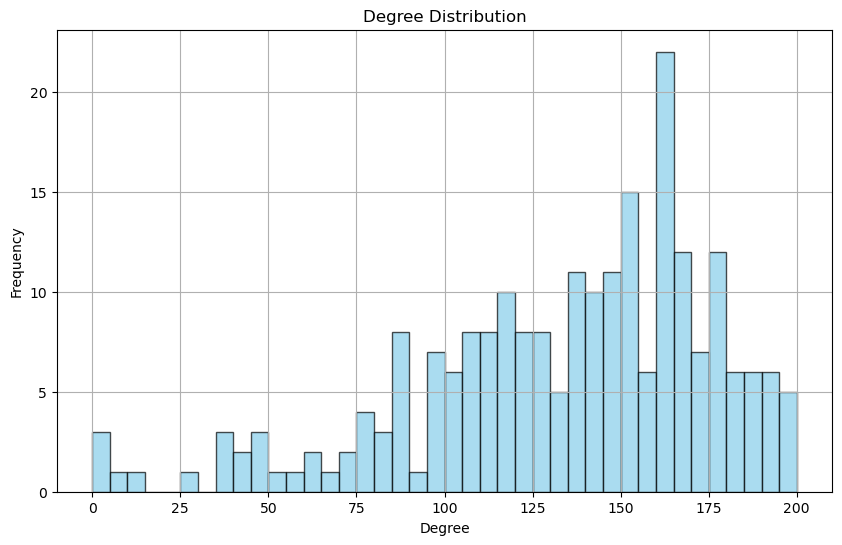

In [24]:
#Plot the histogram of the degree distribution
degrees = [degree for node, degree in G2.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

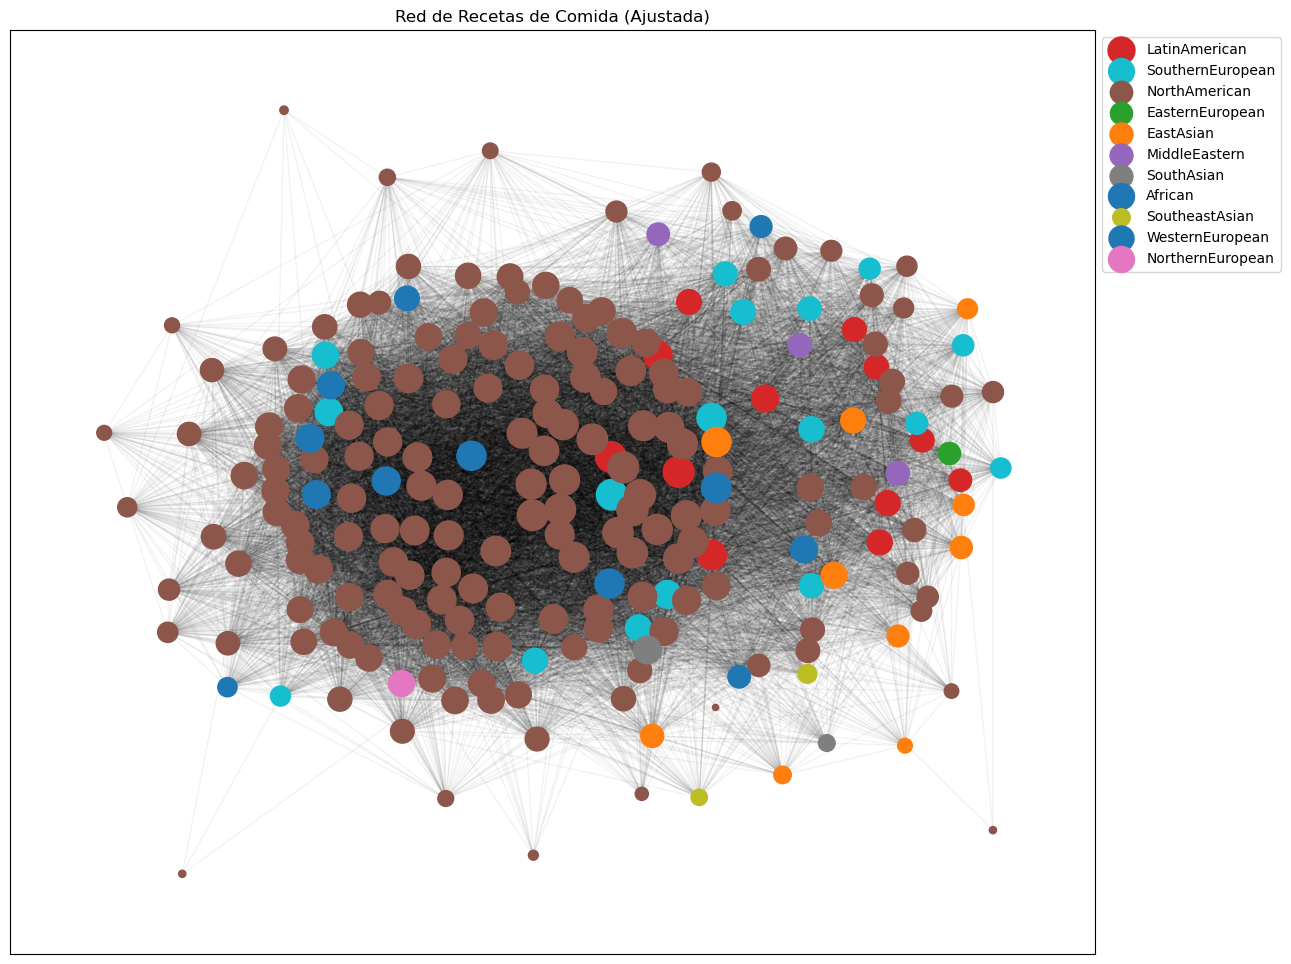

In [25]:
# Obtener los colores de los nodos basados en el tipo de cocina

min_size = 20  # Tamaño mínimo del nodo
max_size = 500  # Tamaño máximo del nodo

# Obtener los grados de los nodos en el grafo G2
grados2 = dict(G2.degree())

# Crear un diccionario de tamaños de nodos
node_sizes2 = {n: min_size + (max_size - min_size) * (grados2[n] - min(grados2.values())) / (max(grados2.values()) - min(grados2.values())) for n in G2.nodes()}

# Ejemplo de ajuste de la visualización de la red
plt.figure(figsize=(14, 12))

# Posiciones de los nodos usando un algoritmo de posicionamiento personalizado (por ejemplo, Kamada-Kawai)
pos2 = nx.kamada_kawai_layout(G2)

# Dibujar nodos con colores distintos para diferentes tipos de comida y tamaños relativos a los grados
for tipo_comida in set(nx.get_node_attributes(G2, 'tipo_comida').values()):
    nodes_of_type = [n for n, d in G2.nodes(data=True) if d['tipo_comida'] == tipo_comida]
    nx.draw_networkx_nodes(G2, pos2, nodelist=nodes_of_type, node_size=[node_sizes2[n] for n in nodes_of_type], node_color=color_dict[tipo_comida], label=tipo_comida)

# Dibujar bordes con transparencia para evitar saturar la imagen
nx.draw_networkx_edges(G2, pos2, alpha=0.05)

# No mostrar etiquetas de los nodos
# nx.draw_networkx_labels(G2, pos2, labels={node: str(node) for node in subset_of_nodes}, bbox=None)

plt.title("Red de Recetas de Comida (Ajustada)- Kamada Kawai")
# Ajustar la posición del legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Red de Recetas de Comida (Ajustada)")
plt.show()

## Latinoamerica

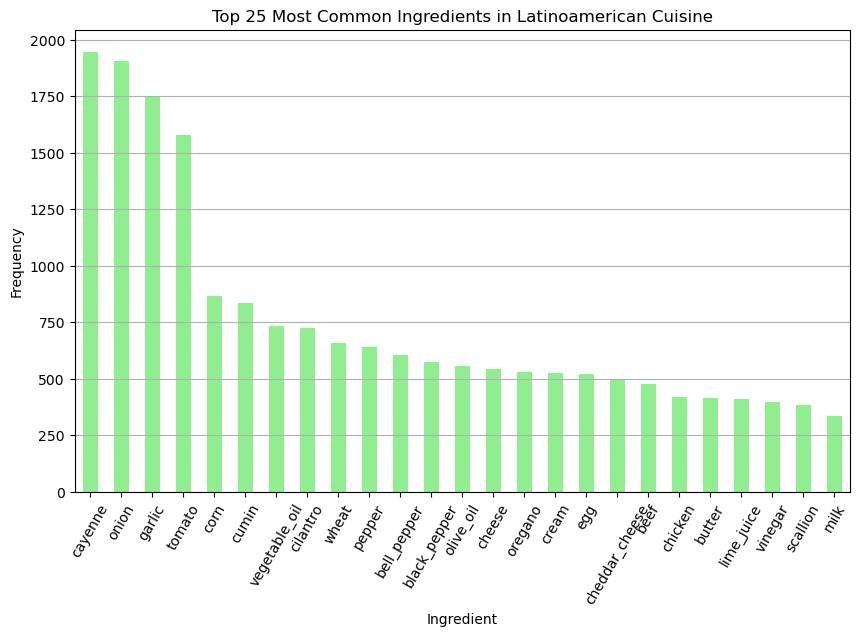

Lista de los 25 ingredientes más comunes en orden:
cayenne: 1946 veces
onion: 1906 veces
garlic: 1752 veces
tomato: 1579 veces
corn: 868 veces
cumin: 833 veces
vegetable_oil: 732 veces
cilantro: 724 veces
wheat: 660 veces
pepper: 640 veces
bell_pepper: 604 veces
black_pepper: 576 veces
olive_oil: 556 veces
cheese: 543 veces
oregano: 529 veces
cream: 525 veces
egg: 519 veces
cheddar_cheese: 495 veces
beef: 475 veces
chicken: 420 veces
butter: 416 veces
lime_juice: 411 veces
vinegar: 397 veces
scallion: 385 veces
milk: 334 veces


In [26]:
# Filtrar el DataFrame para incluir solo recetas con la etiqueta "LatinAmerica"
latin_america_recipes = nuevas_columnas[nuevas_columnas['Type of cuisine'] == 'LatinAmerican']

# Verificar si hay datos para la cocina latinoamericana
if not latin_america_recipes.empty:
    # Apilar los ingredientes y eliminar los valores vacíos ('')
    latinoamerican_stacked = latin_america_recipes.drop(columns=['Type of cuisine']).stack()
    latinoamerican_stacked = latinoamerican_stacked[latinoamerican_stacked != '']

    # Verificar si hay datos apilados
    if not latinoamerican_stacked.empty:
        # Gráfico de barras para mostrar los 25 ingredientes más comunes
        plt.figure(figsize=(10, 6))
        latinoamerican_stacked.value_counts().head(25).plot(kind='bar', color='lightgreen')
        plt.title("Top 25 Most Common Ingredients in Latinoamerican Cuisine")
        plt.xlabel("Ingredient")
        plt.ylabel("Frequency")
        plt.xticks(rotation=60)
        plt.grid(axis='y')
        plt.show()

        # Imprimir la lista de los 25 ingredientes más comunes con su frecuencia
        common_ingredients = latinoamerican_stacked.value_counts().head(25)
        print("Lista de los 25 ingredientes más comunes en orden:")
        for ingredient, count in common_ingredients.items():
            print(f"{ingredient}: {count} veces")
    else:
        print("No hay datos suficientes para generar el gráfico de barras.")
else:
    print("No hay datos para el tipo de cocina 'Latinoamericana'.")


In [27]:
# Create an empty graph
G3 = nx.Graph()

# Filter the DataFrame to include only recipes with the label "LatinAmerica"
latin_america_recipes = nuevas_columnas[nuevas_columnas['Type of cuisine'] == 'LatinAmerican']

# Create a set of unique ingredients for all Latin American recipes
latin_america_ingredients = set()
for _, row in latin_america_recipes.iterrows():
    ingredients = set(row[1:])  # Exclude the first column which is the recipe ID
    latin_america_ingredients.update(ingredients)

# Add nodes to the graph for each Latin American recipe
for i, row in latin_america_recipes.iloc[::4].iterrows():  # Select every 4th recipe
    recipe_id = i
    recipe_ingredients = set(row[1:])  # Exclude the first column which is the recipe ID
    G3.add_node(recipe_id, tipo_comida='LatinAmerican', ingredientes=recipe_ingredients)

# Visualize basic information about the network
print("Number of nodes:", nx.number_of_nodes(G3))

MIN_SHARED_INGREDIENTS = 2

# Add edges between recipes that share a minimum amount of ingredients
for u, data_u in G3.nodes(data=True):
    ingredients_u = data_u['ingredientes']
    for v, data_v in G3.nodes(data=True):
        if u != v:  # Avoid adding edges from a node to itself
            ingredients_v = data_v['ingredientes']
            shared_ingredients = ingredients_u.intersection(ingredients_v)
            if len(shared_ingredients) >= MIN_SHARED_INGREDIENTS:
                G3.add_edge(u, v, shared_ingredients=shared_ingredients)

print("Graph successfully created with", nx.number_of_nodes(G3), "nodes and", nx.number_of_edges(G3), "edges.")


Number of nodes: 730
Graph successfully created with 730 nodes and 212594 edges.


In [28]:
# Central measures
print("Central Measures:")
print("Average Clustering Coefficient:", nx.average_clustering(G3))
print("Average Degree:", np.mean([degree for node, degree in G3.degree()]))
print("Average Closeness Centrality:", np.mean(list(nx.closeness_centrality(G3).values())))
print("Average Betweenness Centrality:", np.mean(list(nx.betweenness_centrality(G3).values())))

# Global measures
print("\nGlobal Measures:")
print("Number of Nodes:", G3.number_of_nodes())
print("Number of Edges:", G3.number_of_edges())
print("Density:", nx.density(G3))
#print("Diameter:", nx.diameter(G3))


Central Measures:
Average Clustering Coefficient: 0.9051780720301357
Average Degree: 582.4493150684932
Average Closeness Centrality: 0.8496899397158346
Average Betweenness Centrality: 0.0002764340156526864

Global Measures:
Number of Nodes: 730
Number of Edges: 212594
Density: 0.7989702538662458


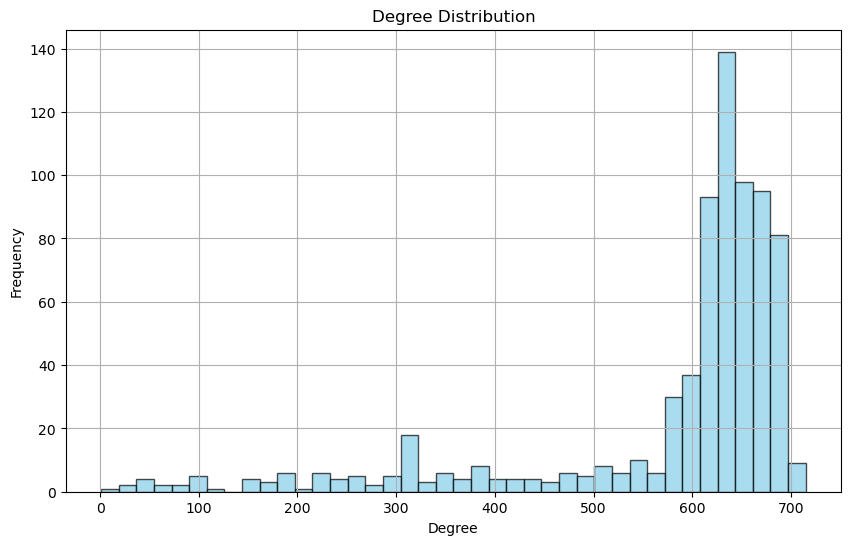

In [29]:
#Plot the histogram of the degree distribution
degrees = [degree for node, degree in G3.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

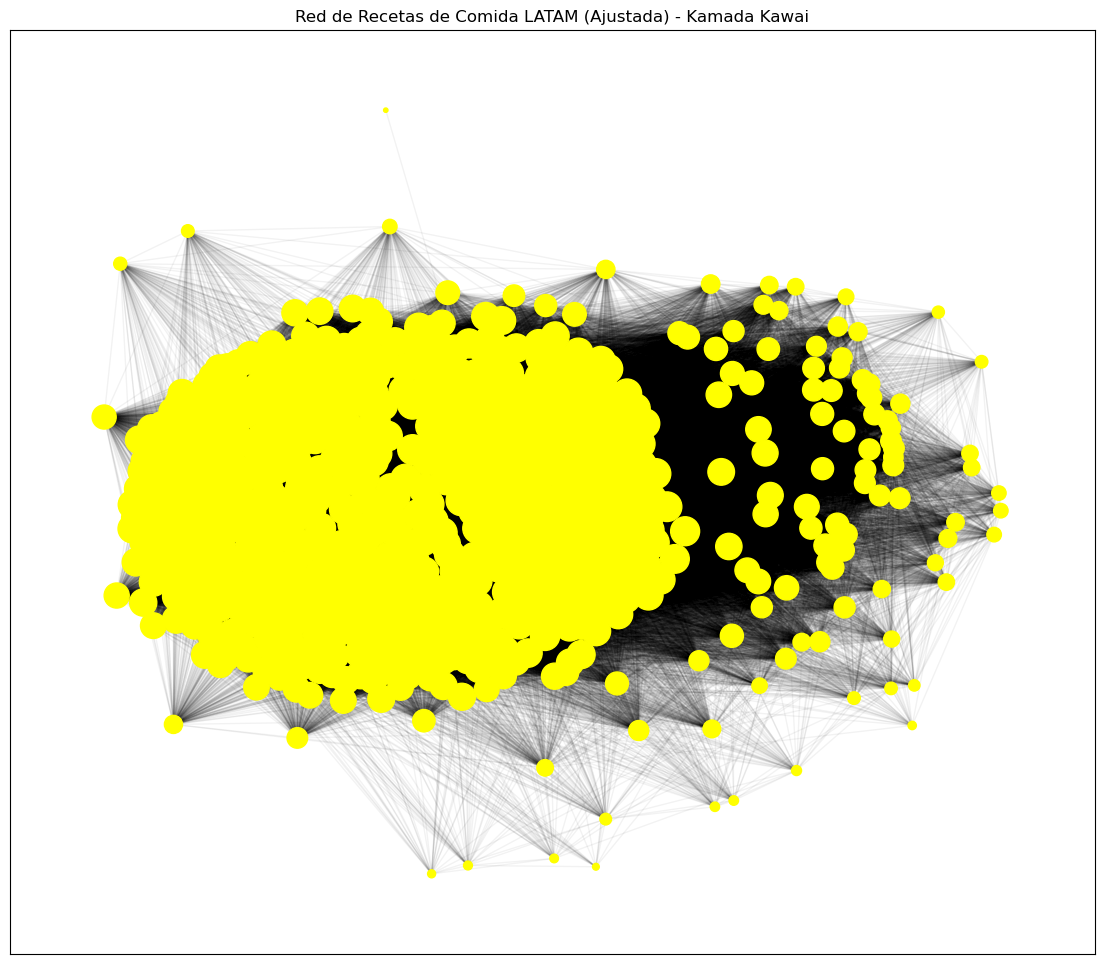

In [30]:
# Set node sizes based on node degrees
min_size = 10  # Minimum node size
max_size = 500  # Maximum node size
grados3 = dict(G3.degree())
node_sizes3 = {n: min_size + (max_size - min_size) * (grados3[n] - min(grados3.values())) / (max(grados3.values()) - min(grados3.values())) for n in G3.nodes()}

# Plot the network
plt.figure(figsize=(14, 12))
pos3 = nx.kamada_kawai_layout(G3)
nx.draw_networkx_nodes(G3, pos3, node_size=[node_sizes3[n] for n in G3.nodes()], node_color='yellow')
nx.draw_networkx_edges(G3, pos3, alpha=0.05)
plt.title("Red de Recetas de Comida LATAM (Ajustada) - Kamada Kawai")
plt.show()

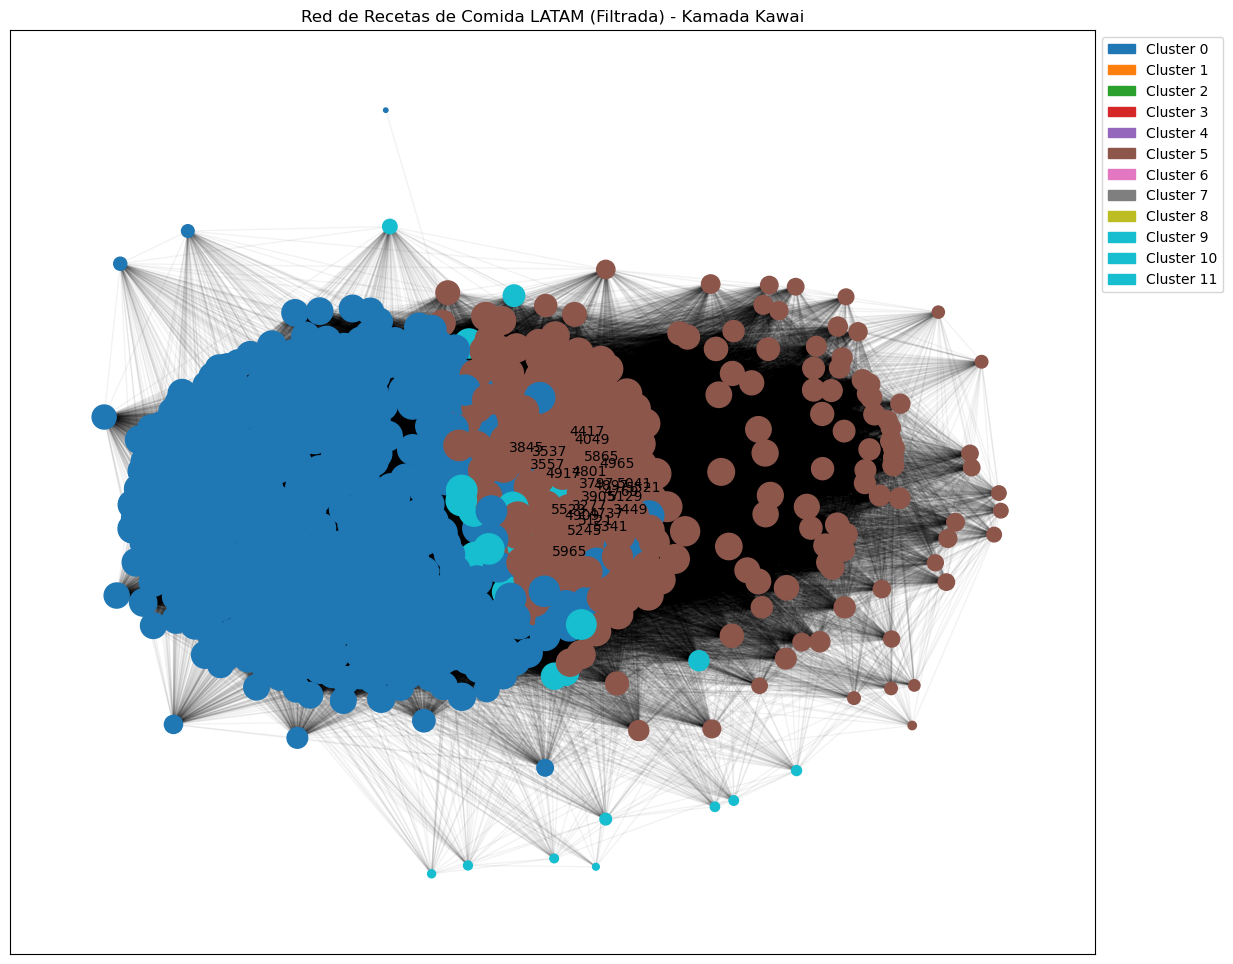

In [34]:
# Detectar comunidades utilizando el algoritmo de Louvain

partition2 = community.best_partition(G3)

# Obtener los 25 nodos de mayor grado
top_nodes = sorted(G3.nodes(), key=lambda x: G3.degree(x), reverse=True)[:25]

# Crear una lista de colores para los nodos basados en los clusters detectados
node_colors3 = [partition2[node] for node in G3.nodes()]

# Plot the network with nodes colored by clusters
plt.figure(figsize=(14, 12))
pos3 = nx.kamada_kawai_layout(G3)
nx.draw_networkx_nodes(G3, pos3, node_size=[node_sizes3[n] for n in G3.nodes()], node_color=node_colors3, cmap=plt.cm.tab10)
nx.draw_networkx_edges(G3, pos3, alpha=0.05)

# Etiquetar los nodos de mayor grado
labels = {}
for node in G3.nodes():
    if node in top_nodes:
        labels[node] = node

nx.draw_networkx_labels(G3, pos3, labels, font_size=10, font_color='black', font_family='sans-serif')

plt.title("Red de Recetas de Comida LATAM (Filtrada) - Kamada Kawai")
# Dibujar la leyenda
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

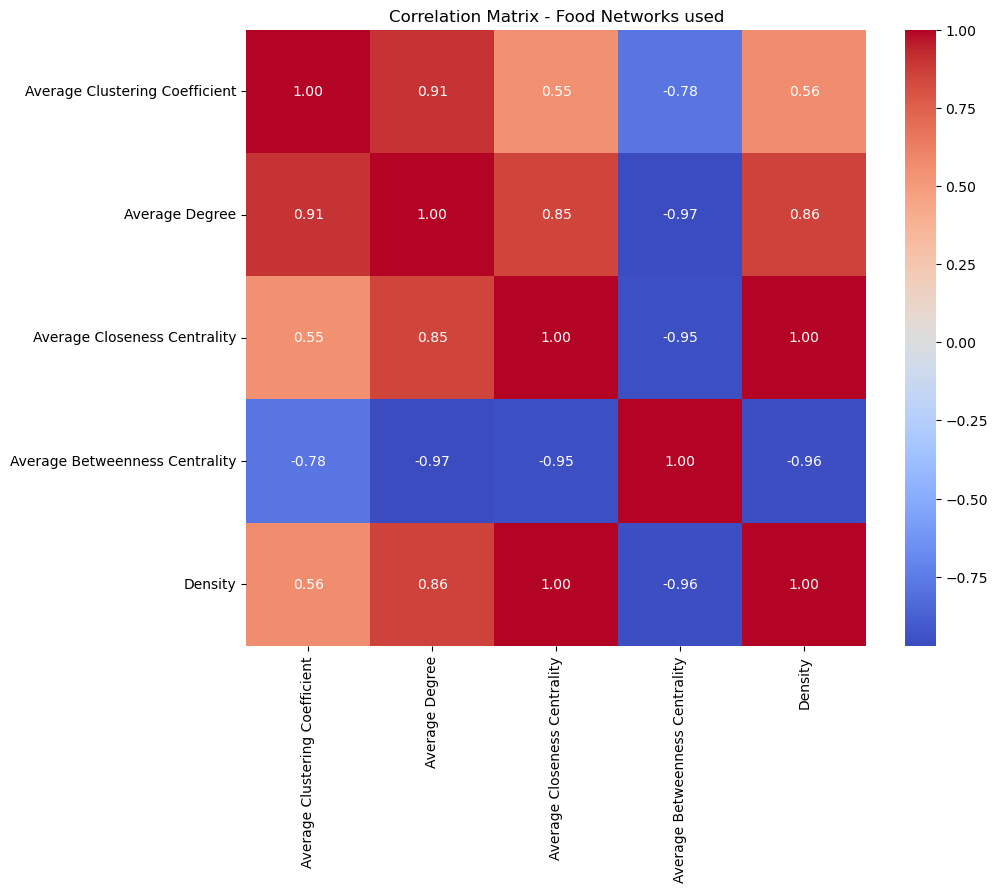

In [40]:
# Calcular medidas para cada red
red1_medidas = {
    "Average Clustering Coefficient": nx.average_clustering(G1),
    "Average Degree": np.mean([grado for nodo, grado in G1.degree()]),
    "Average Closeness Centrality": np.mean(list(nx.closeness_centrality(G1).values())),
    "Average Betweenness Centrality": np.mean(list(nx.betweenness_centrality(G1).values())),
    "Density": nx.density(G1)
}

red2_medidas = {
    "Average Clustering Coefficient": nx.average_clustering(G2),
    "Average Degree": np.mean([grado for nodo, grado in G2.degree()]),
    "Average Closeness Centrality": np.mean(list(nx.closeness_centrality(G2).values())),
    "Average Betweenness Centrality": np.mean(list(nx.betweenness_centrality(G2).values())),
    "Density": nx.density(G2)
}

red3_medidas = {
    "Average Clustering Coefficient": nx.average_clustering(G3),
    "Average Degree": np.mean([grado for nodo, grado in G3.degree()]),
    "Average Closeness Centrality": np.mean(list(nx.closeness_centrality(G3).values())),
    "Average Betweenness Centrality": np.mean(list(nx.betweenness_centrality(G3).values())),
    "Density": nx.density(G3)
}

# Crear DataFrames para cada red
red1_df = pd.DataFrame(red1_medidas, index=["Red 1"])
red2_df = pd.DataFrame(red2_medidas, index=["Red 2"])
red3_df = pd.DataFrame(red3_medidas, index=["Red 3"])

# Concatenar los DataFrames para crear uno solo con todas las medidas
all_reds_df = pd.concat([red1_df,red2_df, red3_df])

# Calcular la correlación entre las medidas
correlation_matrix = all_reds_df.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix - Food Networks used')
plt.show()


In [36]:
import requests

In [38]:
# Lista de los 25 ingredientes más comunes y sus nombres asociados
common_ingredients = {
    'cayenne': 'Cayenne Pepper',
    'onion': 'Onion',
    'garlic': 'Garlic',
    'tomato': 'Tomato',
    'corn': 'Corn',
    'cumin': 'Cumin',
    'vegetable_oil': 'Vegetable Oil',
    'cilantro': 'Cilantro',
    'wheat': 'Wheat',
    'pepper': 'Pepper',
    'bell_pepper': 'Bell Pepper',
    'black_pepper': 'Black Pepper',
    'olive_oil': 'Olive Oil',
    'cheese': 'Cheese',
    'oregano': 'Oregano',
    'cream': 'Cream',
    'egg': 'Egg',
    'cheddar_cheese': 'Cheddar Cheese',
    'beef': 'Beef',
    'chicken': 'Chicken',
    'butter': 'Butter',
    'lime_juice': 'Lime Juice',
    'vinegar': 'Vinegar',
    'scallion': 'Scallion',
    'milk': 'Milk'
}

# URL base de la API
base_url = 'https://api.api-ninjas.com/v1/nutrition'

# Diccionario para almacenar la información nutricional
nutritional_info_dict = {}

# Realizar solicitudes para cada ingrediente en la lista
for ingredient_key, ingredient_name in common_ingredients.items():
    # URL completa de la API con la consulta
    query_url = f'{base_url}?query={ingredient_name}'

    # Realizar la solicitud con la clave de API
    response = requests.get(query_url, headers={'X-Api-Key': '14DDOY2m37rNSq6e6ciFEA==aaesfCLMqxoEhQTN'})

    # Verificar si la solicitud fue exitosa
    if response.status_code == requests.codes.ok:
        # Obtener los datos de nutrición de la respuesta
        data = response.json()
        if data:
            # Agregar información nutricional al diccionario
            nutritional_info_dict[ingredient_name] = data[0]
        else:
            print(f"No se encontraron datos de nutrición para {ingredient_name}")
    else:
        print(f"Error al obtener datos de nutrición para {ingredient_name}: {response.status_code}")

# Crear DataFrame a partir del diccionario de información nutricional
df_info_nutrients = pd.DataFrame.from_dict(nutritional_info_dict, orient='index')

# Imprimir el DataFrame
print("DataFrame df_info_nutrients:")
print(df_info_nutrients)



DataFrame df_info_nutrients:
                          name  calories  serving_size_g  fat_total_g  \
Cayenne Pepper  cayenne pepper     319.8           100.0         17.6   
Onion                    onion      44.7           100.0          0.2   
Garlic                  garlic     144.8           100.0          0.7   
Tomato                  tomato      18.2           100.0          0.2   
Corn                      corn      93.9           100.0          1.5   
Cumin                    cumin     379.3           100.0         22.4   
Vegetable Oil    vegetable oil     877.4           100.0         98.7   
Cilantro              cilantro      22.9           100.0          0.5   
Wheat                    wheat     333.4           100.0          1.9   
Pepper                  pepper     248.5           100.0          3.0   
Bell Pepper        bell pepper      27.6           100.0          0.2   
Black Pepper      black pepper     245.3           100.0          3.0   
Olive Oil            o

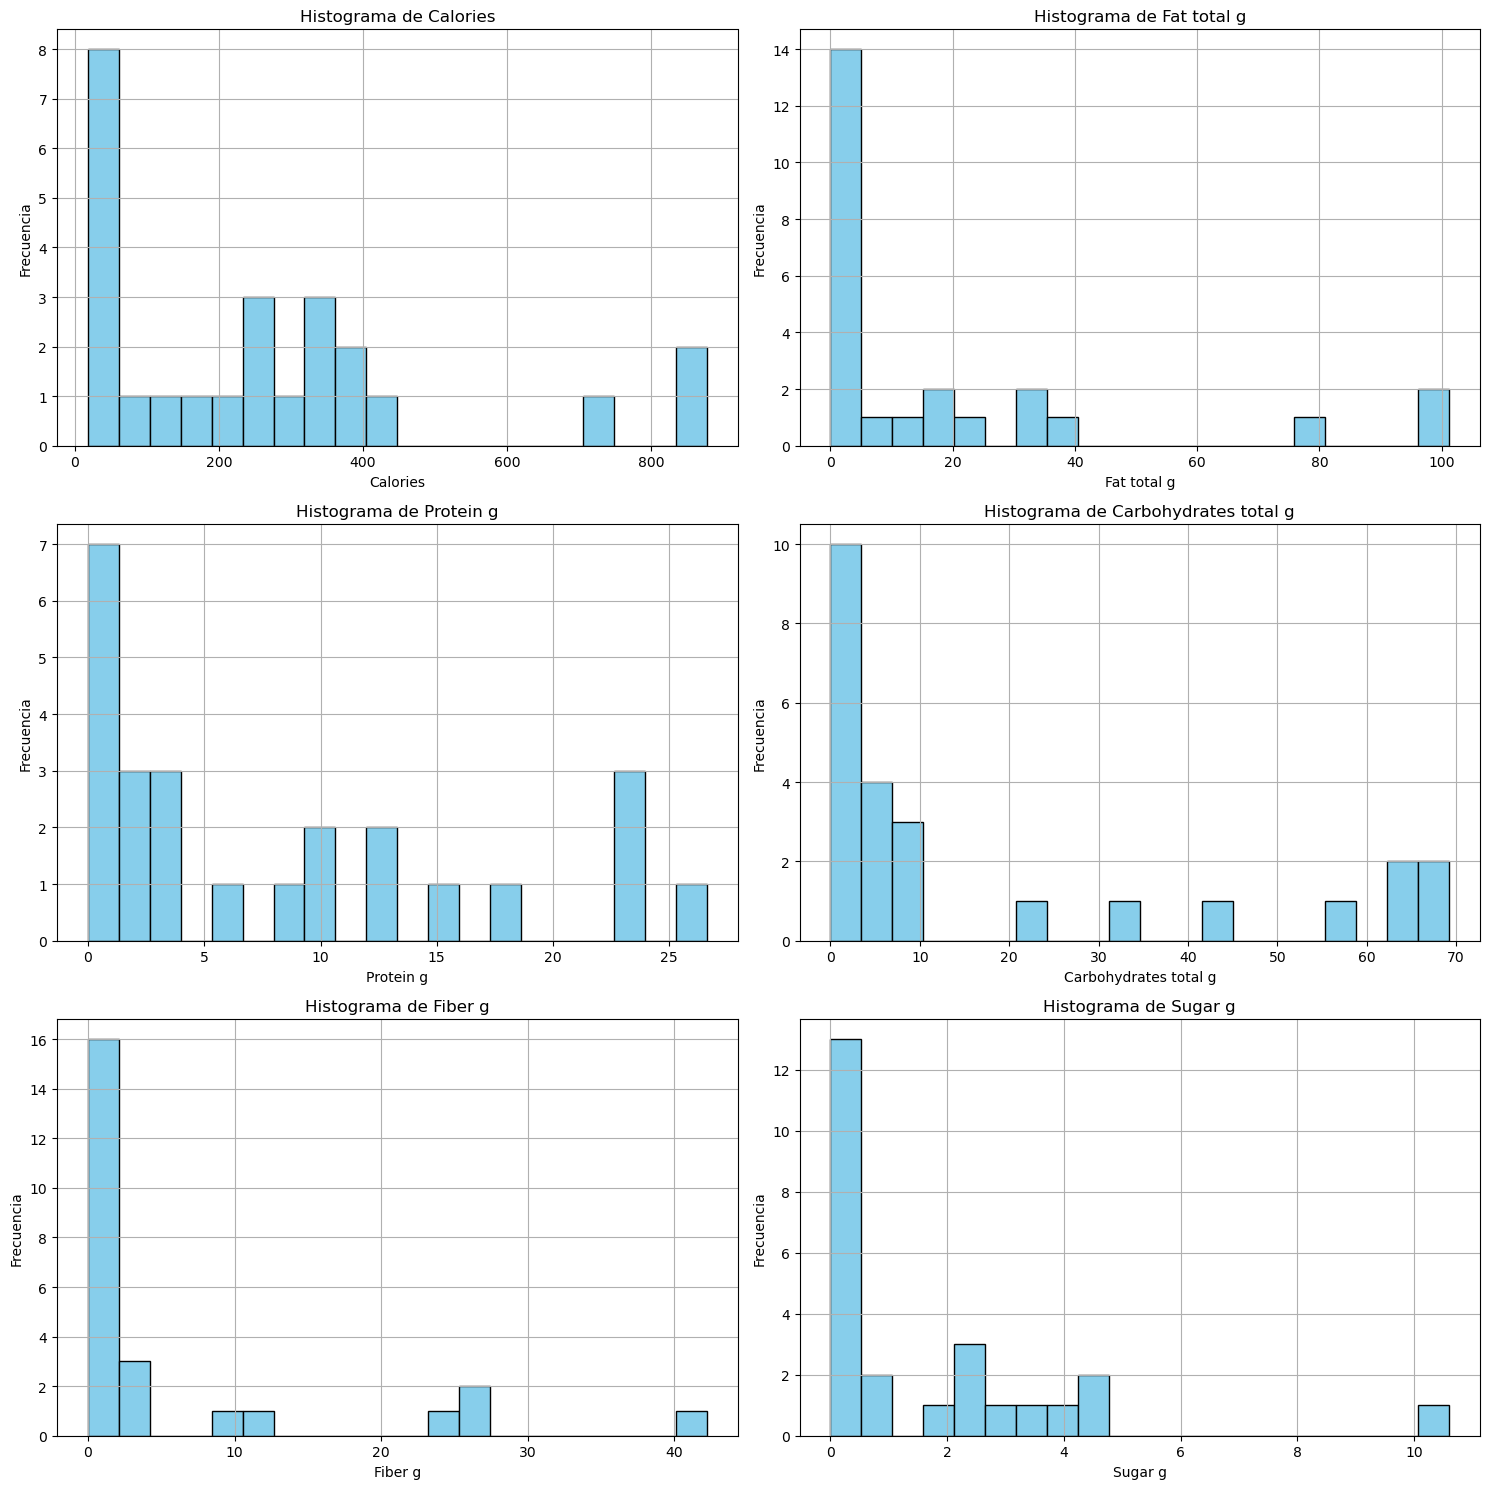

In [52]:
# Crear una figura y ejes para los subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Histogramas de calorías, grasa, proteína, carbohidratos, fibra y azúcar
nutrientes = ['calories', 'fat_total_g', 'protein_g', 'carbohydrates_total_g', 'fiber_g', 'sugar_g']
for i, nutrient in enumerate(nutrientes):
    # Calcular la posición de los subplots en la matriz 3x2
    row = i // 2
    col = i % 2
    # Crear el histograma en el subplot correspondiente
    axs[row, col].hist(df_info_nutrients[nutrient], bins=20, color='skyblue', edgecolor='black')
    axs[row, col].set_title(f'Histograma de {nutrient.capitalize().replace("_", " ")}')
    axs[row, col].set_xlabel(nutrient.capitalize().replace("_", " "))
    axs[row, col].set_ylabel('Frecuencia')
    axs[row, col].grid(True)


# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


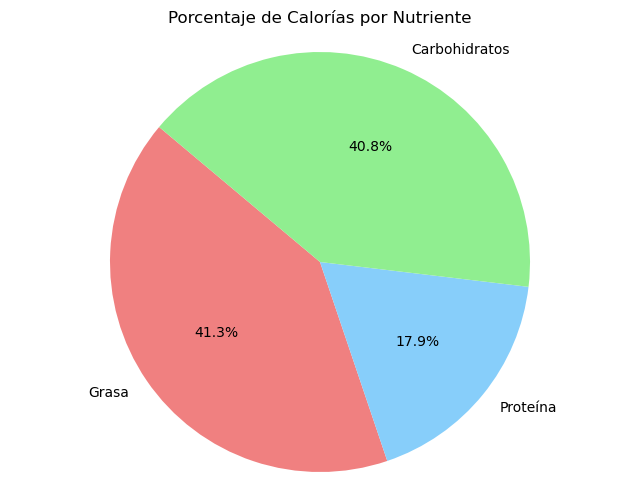

In [50]:
# Diagrama de Pie de Porcentaje de Nutrientes
total_calorias = df_info_nutrients['calories'].sum()
total_grasa = df_info_nutrients['fat_total_g'].sum()
total_proteina = df_info_nutrients['protein_g'].sum()
total_carbohidratos = df_info_nutrients['carbohydrates_total_g'].sum()

porcentajes = [total_grasa / total_calorias * 100, total_proteina / total_calorias * 100, total_carbohidratos / total_calorias * 100]
nombres = ['Grasa', 'Proteína', 'Carbohidratos']
colores = ['lightcoral', 'lightskyblue', 'lightgreen']

plt.figure(figsize=(8, 6))
plt.pie(porcentajes, labels=nombres, colors=colores, autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Calorías por Nutriente')
plt.axis('equal')
plt.show()

In [39]:
# Diccionario corregido de enfermedades asociadas a ingredientes
ingredient_diseases = {
    'cayenne': ['Indigestión', 'Circulación sanguínea'],
    'onion': ['Presión arterial alta', 'Diabetes'],
    'garlic': ['Presión arterial alta', 'Colesterol alto'],
    'tomato': ['Antioxidante', 'Cáncer'],
    'corn': ['Energía', 'Digestión'],
    'cumin': ['Digestión', 'Inflamación'],
    'vegetable_oil': ['Colesterol alto', 'Inflamación'],
    'cilantro': ['Digestión', 'Inflamación'],
    'wheat': ['Energía', 'Digestión'],
    'pepper': ['Digestión', 'Inflamación'],
    'bell_pepper': ['Antioxidante', 'Inflamación'],
    'black_pepper': ['Digestión', 'Inflamación'],
    'olive_oil': ['Colesterol alto', 'Inflamación'],
    'cheese': ['Colesterol alto', 'Cáncer'],
    'oregano': ['Digestión', 'Inflamación'],
    'cream': ['Colesterol alto', 'Diabetes'],
    'egg': ['Protección ocular', 'Pérdida de peso'],
    'cheddar_cheese': ['Colesterol alto', 'Cáncer'],
    'beef': ['Energía', 'Cáncer'],
    'chicken': ['Energía', 'Cáncer'],
    'butter': ['Colesterol alto', 'Inflamación'],
    'lime_juice': ['Antioxidante', 'Inflamación'],
    'vinegar': ['Digestión', 'Inflamación'],
    'scallion': ['Digestión', 'Inflamación'],
    'milk': ['Osteoporosis', 'Enfermedades cardiovasculares']
}

# Crear un DataFrame a partir del diccionario
df_ingredient_diseases = pd.DataFrame.from_dict(ingredient_diseases, orient='index', columns=['Enfermedad 1', 'Enfermedad 2'])

# Imprimir el diccionario
print("Diccionario ingredient_diseases:")
print(ingredient_diseases)
print()

# Imprimir el DataFrame
print("DataFrame df_ingredient_diseases:")
print(df_ingredient_diseases)


Diccionario ingredient_diseases:
{'cayenne': ['Indigestión', 'Circulación sanguínea'], 'onion': ['Presión arterial alta', 'Diabetes'], 'garlic': ['Presión arterial alta', 'Colesterol alto'], 'tomato': ['Antioxidante', 'Cáncer'], 'corn': ['Energía', 'Digestión'], 'cumin': ['Digestión', 'Inflamación'], 'vegetable_oil': ['Colesterol alto', 'Inflamación'], 'cilantro': ['Digestión', 'Inflamación'], 'wheat': ['Energía', 'Digestión'], 'pepper': ['Digestión', 'Inflamación'], 'bell_pepper': ['Antioxidante', 'Inflamación'], 'black_pepper': ['Digestión', 'Inflamación'], 'olive_oil': ['Colesterol alto', 'Inflamación'], 'cheese': ['Colesterol alto', 'Cáncer'], 'oregano': ['Digestión', 'Inflamación'], 'cream': ['Colesterol alto', 'Diabetes'], 'egg': ['Protección ocular', 'Pérdida de peso'], 'cheddar_cheese': ['Colesterol alto', 'Cáncer'], 'beef': ['Energía', 'Cáncer'], 'chicken': ['Energía', 'Cáncer'], 'butter': ['Colesterol alto', 'Inflamación'], 'lime_juice': ['Antioxidante', 'Inflamación'], 'vine

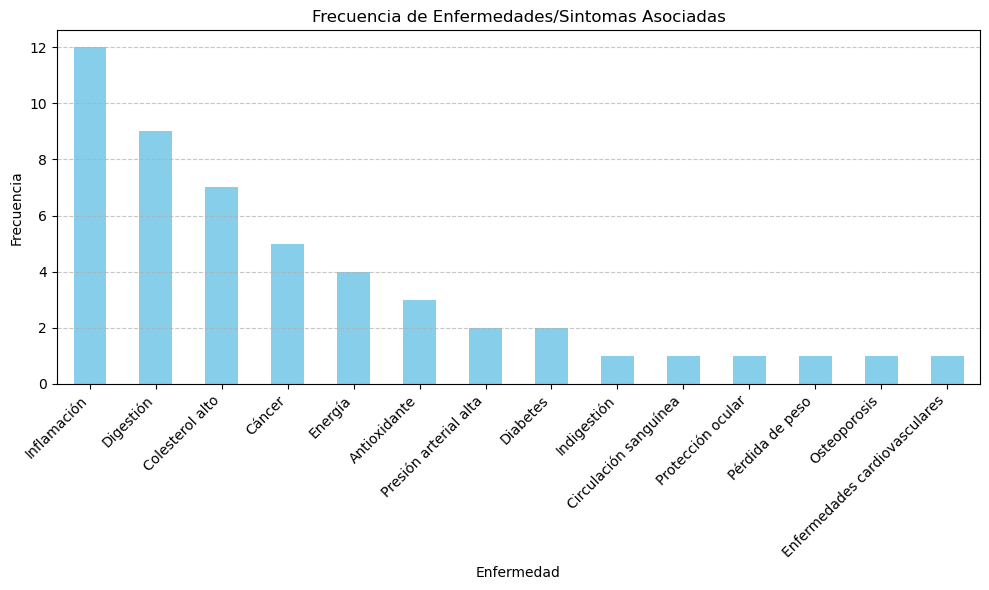

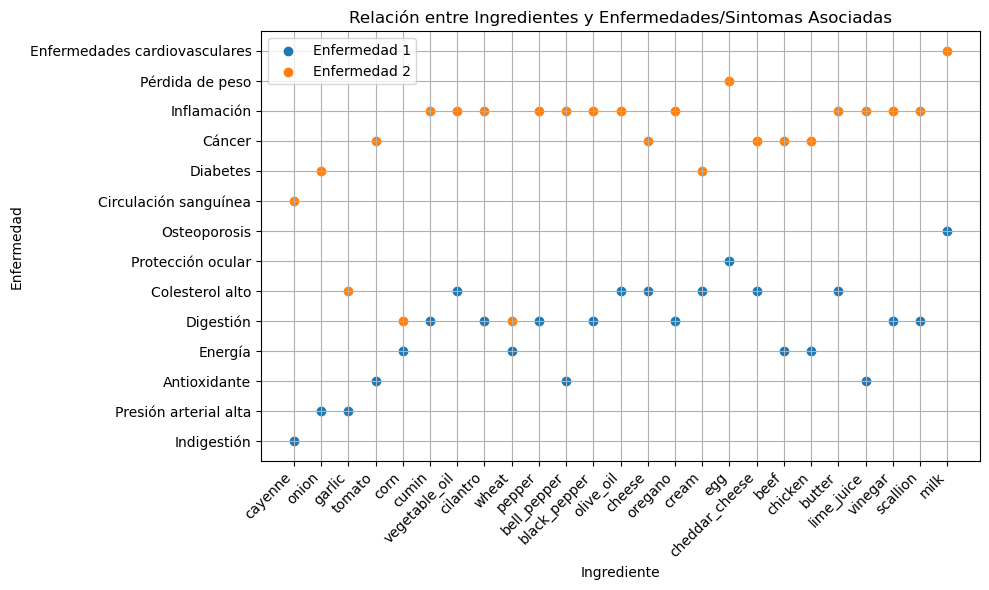

In [46]:
# Diagrama de barras de enfermedades asociadas
enfermedades = df_ingredient_diseases.values.flatten()
enfermedad_counts = pd.Series(enfermedades).value_counts()

plt.figure(figsize=(10, 6))
enfermedad_counts.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de Enfermedades/Sintomas Asociadas')
plt.xlabel('Enfermedad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Diagrama de dispersión de ingredientes y enfermedades
plt.figure(figsize=(10, 6))
for enfermedad in df_ingredient_diseases.columns:
    plt.scatter(df_ingredient_diseases.index, df_ingredient_diseases[enfermedad], label=enfermedad)
plt.title('Relación entre Ingredientes y Enfermedades/Sintomas Asociadas')
plt.xlabel('Ingrediente')
plt.ylabel('Enfermedad')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
compounds_file = pd.read_csv('data/compounds.tsv',index_col=0,sep='\t').to_dict('index')
ingredients_file = pd.read_csv('data/ingredients.tsv',index_col=0,sep='\t').to_dict('index')
ingredient_compound_file = pd.read_csv('data/ingredient-compound.tsv',sep='\t')

### The ingredient_compound file is a table whose values are the ids of ingredients and compounds, we just process it to use the names
def getBipartiteIngredientCompoundNetworkDF(ingredient_compound_file):
  new_df=pd.DataFrame()
  new_df['Ingredient']=ingredient_compound_file['# ingredient id'].apply(lambda x: ingredients_file[x]['ingredient name'])
  new_df['Compound']=ingredient_compound_file['compound id'].apply(lambda x: compounds_file[x]['Compound name'])
  return new_df

### The recipes_file is processed to obtain a dataFrame whose columns are the cousine (European, Latin, ..) and the ingredients list of the recipe
def processRecipesFile(recipes_file):
  df = recipes_file.copy()
  df.columns=['cousine']
  df['ingredients'] = df['cousine'].apply(lambda x: x.split(',')[1:])
  df['cousine'] = df['cousine'].apply(lambda x: x.split(',')[0])
  return df

### Function to get the ingredients set of a Recipes DataFrame. It is valuable, because we can process just one recipe or a subset of recipes and get the set of ingredients contained.
def getIngredientsSet(recipes):
  ingredients_set = set()
  recipes.ingredients.map(lambda x: [ingredients_set.add(i) for i in x])
  return ingredients_set



### Function to build the Dataset whose columns are Ingredient1ID, Ingredient2ID and the Number of Shared Components by two ingredients 
def getFlavorNetworkDF(ingredient_compound_file, ingredients_file):
  aux=ingredient_compound_file['# ingredient id'].unique()
  aux.sort()
  new_df=getPairsOfIngredients(pd.DataFrame(aux,columns=['Ingredient']))
  compound_groups=dict(ingredient_compound_file.groupby('# ingredient id')['compound id'].apply(set))
  new_df['NumSharedComponents']=new_df.apply(lambda row: len(compound_groups[row['Ingredient1ID']].intersection(compound_groups[row['Ingredient2ID']])),axis=1)
  #Now we would like to add the category of the first Ingredient and the category of the Second Ingredient
  new_df2=new_df[new_df['NumSharedComponents']>0].copy()
  new_df2['Ingredient1']=new_df2['Ingredient1ID'].apply(lambda x: ingredients_file[x]['ingredient name'])
  new_df2['Ingredient2']=new_df2['Ingredient2ID'].apply(lambda x: ingredients_file[x]['ingredient name'])
  return new_df2

def filterIngredientsFromRecipes(df, ingredients_set):
  filtered_df = df[df['Ingredient1'].isin(ingredients_set)].copy()
  filtered_df = filtered_df[filtered_df['Ingredient2'].isin(ingredients_set)]
  return filtered_df



In [ ]:
recipes = processRecipesFile(recipes_file)
ingredients_from_recipes = getIngredientsSet(recipes)
recipes_flavor_network_df=filterIngredientsFromRecipes(full_flavor_network_df,ingredients_from_recipes)


bipartite_ingredient_compound_network_df = getBipartiteIngredientCompoundNetworkDF(ingredient_compound_file)
full_flavor_network_df = getFlavorNetworkDF(ingredient_compound_file, ingredients_file)

G=nx.from_pandas_edgelist(recipes_flavor_network_df, source='Ingredient1', target='Ingredient2', edge_attr=True)
G_backbone=extractBackbone(G,alpha=0.04,weight_attribute='NumSharedComponents')

G_backbone_df=nx.to_pandas_edgelist(G_backbone)
nodes=getNodesFromBackbone(G_backbone_df,ingredients_file,recipes)

## Export to Gephi: Load separately edges.csv and nodes.csv
edges=G_backbone_df[['Ingredient1ID','Ingredient2ID','NumSharedComponents']]
edges.columns=['Source','Target','Weight']
edges.to_csv('edges.csv',index=False)
nodes.to_csv('nodes.csv',index=False)